In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, probplot
import datetime as dt

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
threshold = -0.03
period = 1
plt.style.use('seaborn-poster')

<ipython-input-2-3c7781759c49>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [ ]:
# Get the yf ticker
spx_ticker = '^GSPC'
tickers = yf.Tickers(spx_ticker)

# Get maximum history (< 100y)
df_spx = tickers.tickers[spx_ticker].history(period='100y')[['Close']]

# Compute the log close and the log returns
df_spx['log_close'] = df_spx['Close'].map(np.log)
df_spx['log_close_diff_period'] = df_spx['log_close'].diff(periods=period)

# display the data
df_spx.head()

,Close,log_close,log_close_diff_period
Date,,,
1927-12-30 00:00:00-05:00,17.660000,2.871302,NaN
1928-01-03 00:00:00-05:00,17.760000,2.876949,0.005647
1928-01-04 00:00:00-05:00,17.719999,2.874694,-0.002255
1928-01-05 00:00:00-05:00,17.549999,2.865054,-0.009640
1928-01-06 00:00:00-05:00,17.660000,2.871302,0.006248


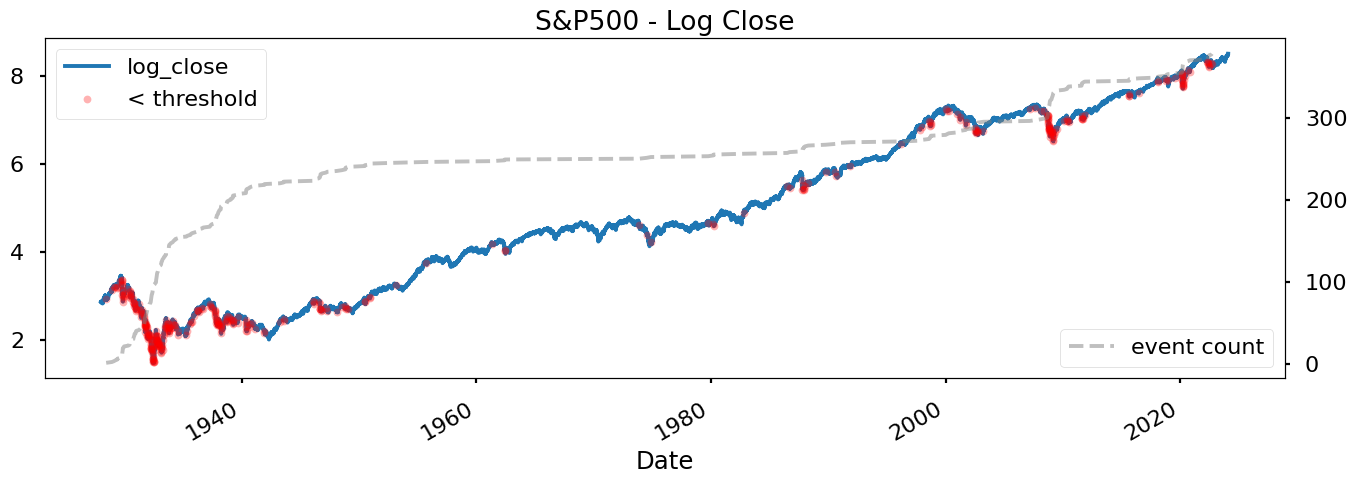

In [ ]:
ax = df_spx['log_close'].plot()
ax.set_title('S&P500 - Log Close');

df_spx[
    df_spx['log_close_diff_period'] < threshold
      ]['log_close'].plot(style='.', color='red', label='< threshold', ax=ax, alpha=0.3)

ax2 = ax.twinx()
df_spx[1] = 1
df_spx[
    df_spx['log_close_diff_period'] < threshold
      ][1].cumsum().plot(style='--', color='grey', label='event count', ax=ax2, alpha=0.5)

ax2.legend(loc = 'lower right')
ax.legend(loc = 'upper left');
plt.gcf().set_size_inches(16,5);

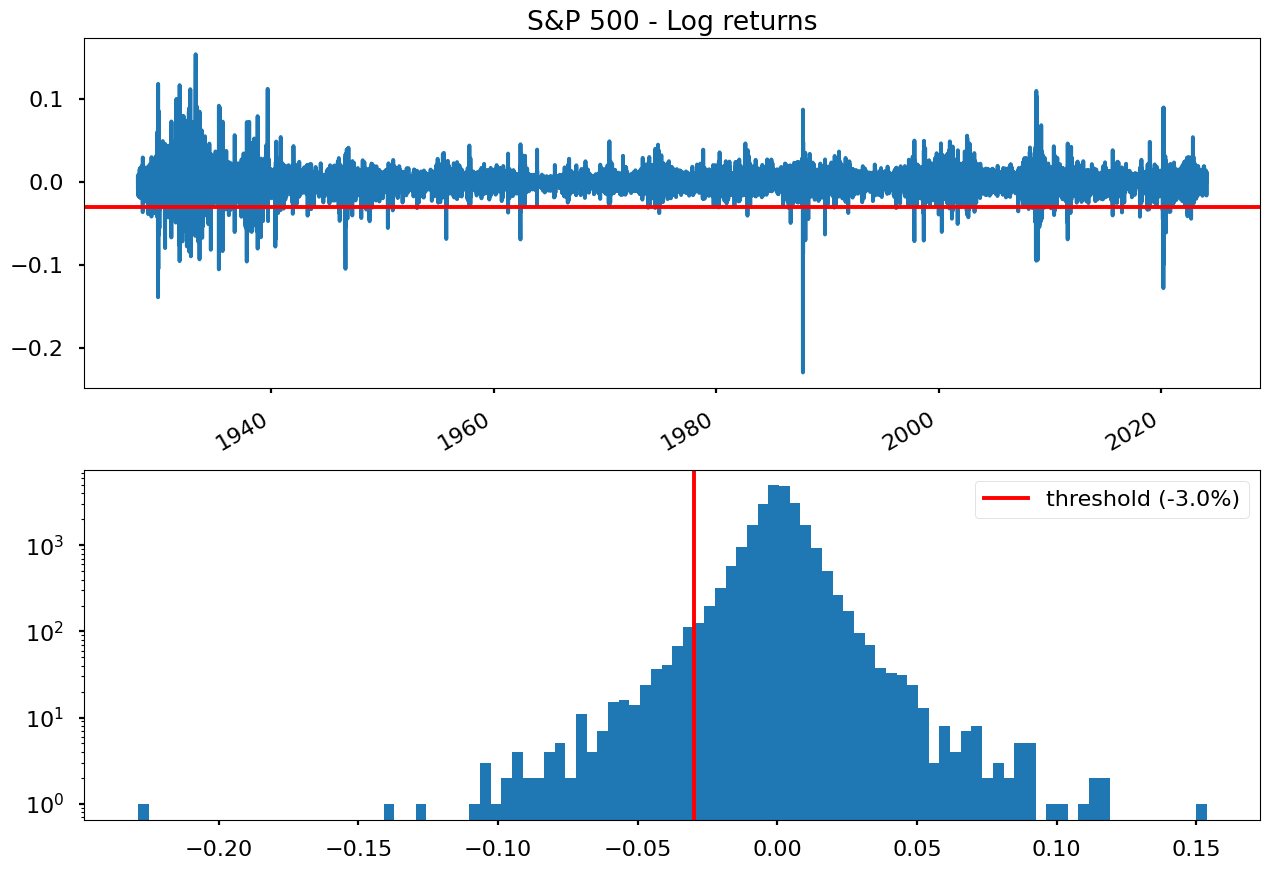

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2)

df_spx['log_close_diff_period'].plot(ax=ax)
ax.axhline(threshold, color='red', label='threshold')
ax.set_title('S&P 500 - Log returns');
ax.set_xlabel('')

ax = ax1
df_spx['log_close_diff_period'].hist(bins=100, ax=ax)

ax.set_yscale('log')

ax.grid(False)
ax.axvline(threshold, color='red', label=f'threshold ({100*threshold}%)');
ax.legend();


fig.tight_layout()

Getting extreme points

In [ ]:
# Get the points above the threshold POT approach
_se = df_spx[
    df_spx['log_close_diff_period'] < threshold
      ]['log_close_diff_period']

# Make the extreme points positive
df_pot = (-_se + threshold).to_frame().reset_index()
df_pot['ccdf'] = df_pot['log_close_diff_period'].rank(pct=True, ascending=False)

In [ ]:
# Fit genpareto dist
param_fit = genpareto.fit(df_pot['log_close_diff_period'], floc=0)
c, loc, scale = param_fit

print(f'GPD parameters fit:\nc     = {c} \nloc   = {loc} \nscale = {scale}')

GPD parameters fit:
c     = 0.2637215930022003 
loc   = 0 
scale = 0.011294834188157073


Xi Likelihood

In [ ]:
%%time
def compute_grid_likelihood(df_pot, start=0.001, end=3, sample=1000):
    '''
    Computes the grid likelihood distribution of the shape parameter c of genpareto

    Args:
        - df: [ log_close_diff_period > threshold ]
    '''

    c_space = np.linspace(start,end,sample)

    # take the empirical distribution
    c_dist = [[_c, genpareto(c=_c, loc=loc, scale=scale).logpdf(df_pot['log_close_diff_period']).sum()] for _c in c_space]

    df_c = pd.DataFrame(c_dist, columns=['xi', 'log_likelihood'])
    df_c = df_c.replace([-np.inf, np.inf], np.nan).dropna()

    # Add a constant before applying the exp
    df_c['log_likelihood_scaled'] = df_c['log_likelihood'] - df_c['log_likelihood'].max()
    df_c['likelihood_scaled'] = df_c['log_likelihood_scaled'].map(np.exp)
    df_c['likelihood_scaled'] = df_c['likelihood_scaled']/df_c['likelihood_scaled'].sum()
    df_c = df_c.set_index('xi')
    return df_c

df_c = compute_grid_likelihood(df_pot=df_pot.copy())
df_c.head()

CPU times: user 1.42 s, sys: 6.96 ms, total: 1.42 s
Wall time: 1.89 s


,log_likelihood,log_likelihood_scaled,likelihood_scaled
xi,,,
0.001000,1187.794939,-29.262604,4.444310e-15
0.004002,1188.954763,-28.102780,1.417456e-14
0.007004,1190.062031,-26.995512,4.289336e-14
0.010006,1191.120561,-25.936983,1.236242e-13
0.013008,1192.133718,-24.923826,3.404960e-13


In [ ]:
def confidence_interval(df, level=0.95, bool_unsafe=True):
    '''
    Computes the confidence interval starting from the maximum value and
    iteratively including the highest neighboor.

    Args:
        - df: [ (xi) | likelihood_scaled ]

    '''

    if not bool_unsafe:
        assert np.abs(df['likelihood_scaled'].sum() - 1) < 1e-4

    idx = df.index.name
    df = df.sort_index()['likelihood_scaled'].cumsum().rename('P').reset_index()
    ml_idx = df['P'].diff().argmax()
    se_slope = df['P'].diff()/df[idx].diff()
    a=b=0

    try:
        while df.iloc[ml_idx+b+1]['P'] - df.iloc[ml_idx-a]['P'] < level:
            if ml_idx-(a+1) < 1:
                b=b+1
                continue
            if ml_idx+b+1 >= len(df):
                a=a+1
                continue

            slope_a = se_slope.iloc[ml_idx-a]
            slope_b = se_slope.iloc[ml_idx+b+1]

            if slope_b < slope_a:
                a=a+1
            else:
                b=b+1
    except:
        return np.nan, np.nan

    list_ret = df[idx].iloc[[ml_idx-a,ml_idx+b+1]].to_list()

    # TODO: debug the case when max < min
    if list_ret[0] > list_ret[1]:
        return np.nan, np.nan

    return list_ret[0], list_ret[1]

In [ ]:
xi_low, xi_high = confidence_interval(df=df_c.copy())

print(f'xi 95% confidence interval :\n {[xi_low, xi_high]}')


xi 95% confidence interval :
 [0.1691121121121121, 0.37925225225225223]


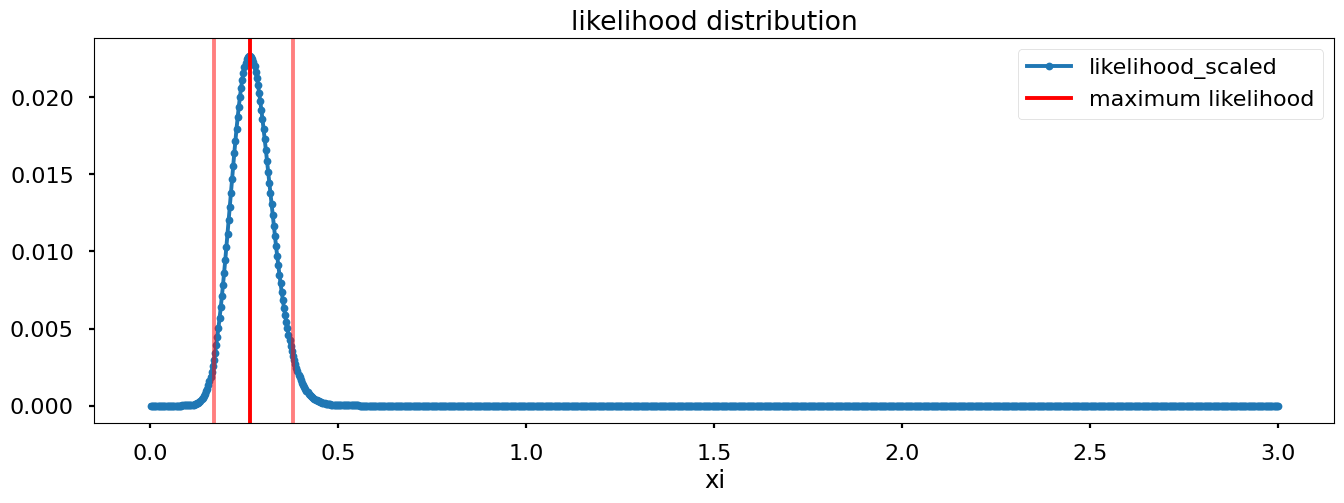

In [ ]:
ax = df_c[['likelihood_scaled']].plot(style='.-')
ax.axvline(c, color='red', label='maximum likelihood')
ax.axvline(xi_low, color='red', alpha=0.5)
ax.axvline(xi_high, color='red', alpha=0.5)

ax.legend();
ax.set_title('likelihood distribution');
# ax.set_xscale('log');
# ax.set_yscale('log');

plt.gcf().set_size_inches(16,5);

Estimating VaR and ES

In [ ]:
def VaR_ES(u, c, scale, N, Nu, alpha = 0.95):

    _u = -u

    VaR = _u + scale/c*((np.power((N/Nu*(1-alpha)), -c))-1)
    ES = (VaR + scale - c*(_u))/(1-c)

    return VaR, ES

alpha = 0.99
N  = len(df_spx[df_spx['log_close_diff_period'] < 0])
Nu = len(df_spx[df_spx['log_close_diff_period'] < threshold])
VaR, ES = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=alpha)

print(f'VaR  : {VaR}\nES   : {ES}\nN    : {N}\nNu   : {Nu}\nalpha: {alpha}')

VaR  : 0.046215150958462174
ES   : 0.06736356368074428
N    : 11188
Nu   : 378
alpha: 0.99


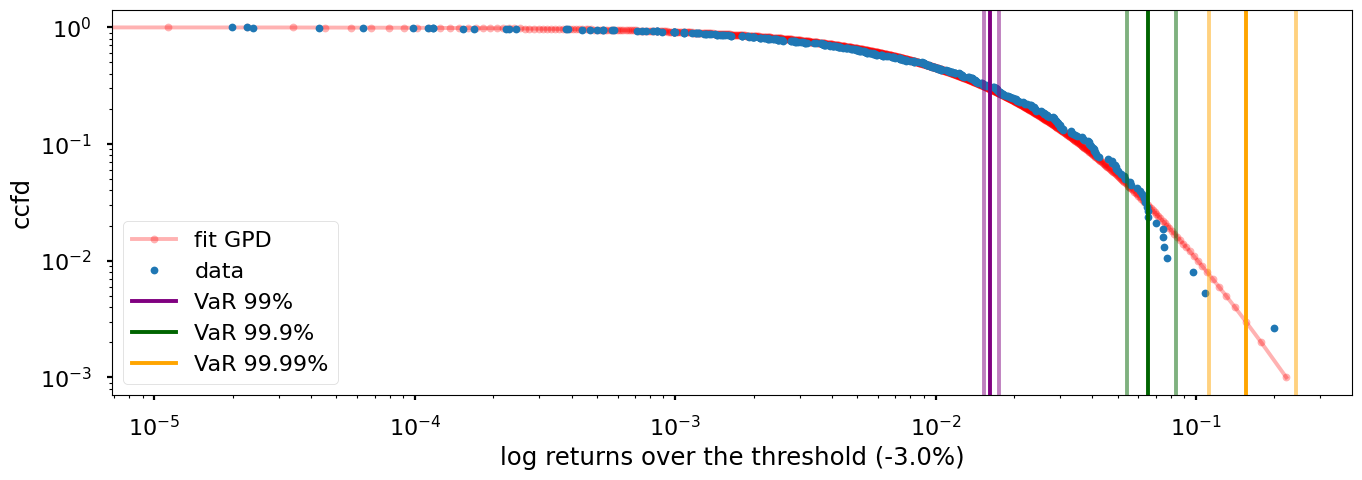

In [ ]:
c, loc, scale = param_fit
ax = plt.gca()

# Plot genpareto fit
x = np.linspace(0,1,num=1000)
y = genpareto.ppf(q=x, c=c, loc=loc, scale=scale)
ax.plot(y,1-x, 'r.-', label='fit GPD', alpha=0.3)

# plot data
df_pot.set_index('log_close_diff_period')['ccdf'].plot(style='.', ax=ax, label='data')

# plot risk estimates
ax.axvline(VaR-(-threshold), label='VaR 99%', color='purple')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.99)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.99)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='purple')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='purple')


VaR2, _ = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=0.999)
ax.axvline(VaR2-(-threshold), label='VaR 99.9%', color='darkgreen')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.999)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.999)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='darkgreen')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='darkgreen')


VaR3, _ = VaR_ES(u=threshold, c=c, scale=scale, N=N, Nu=Nu, alpha=0.9999)
ax.axvline(VaR3-(-threshold), label='VaR 99.99%', color='orange')
VaR_lo, _ = VaR_ES(u=threshold, c=xi_low, scale=scale, N=N, Nu=Nu, alpha=0.9999)
VaR_hi, _ = VaR_ES(u=threshold, c=xi_high, scale=scale, N=N, Nu=Nu, alpha=0.9999)
ax.axvline(VaR_lo-(-threshold), alpha=0.5, color='orange')
ax.axvline(VaR_hi-(-threshold), alpha=0.5, color='orange')

# configure plot
ax.legend()
ax.set_xlabel(f'log returns over the threshold ({threshold*100}%)')
ax.set_ylabel('ccfd')
ax.set_xscale('log')
ax.set_yscale('log');


plt.gcf().set_size_inches(16,5);

Running the above analysis for many companies and storing the results

In [ ]:
# Create custom function to compute the beta of an asset
#
#     Note: beta is a measure of how much can the market
#           explain the returns of one of its assets
#

def compute_beta(df_tic, df_spx=df_spx):
    _df = df_spx[['log_close_diff_period']].join(df_tic[['log_close_diff_period']], rsuffix='_')
    beta = _df.corr().min().min()*_df['log_close_diff_period_'].std()/_df['log_close_diff_period'].std()
    return beta

In [ ]:
# Testing tickers
list_tickers = ['^GSPC','AAPL','IBM','GM',
                'TSLA','JPM','META','JNJ',
                'XOM','PG','V','PFE',
                'AMZN','KO','MCD','DIS','NVDA']

In [ ]:
## All S&P500 tickers
## Source: https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

# list_tickers = ['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DISH', 'DIS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DTE', 'DUK', 'DRE', 'DD', 'DXC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'RE', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FAST', 'FRT', 'FDX', 'FITB', 'FRC', 'FE', 'FIS', 'FISV', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FBHS', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GL', 'GPN', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IQV', 'IRM', 'JBHT', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OGN', 'OTIS', 'PCAR', 'PKG', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PENN', 'PNR', 'PEP', 'PKI', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SBNY', 'SPG', 'SWKS', 'SJM', 'SNA', 'SEDG', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TWTR', 'TYL', 'TSN', 'USB', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VNO', 'VMC', 'WAB', 'WBA', 'WMT', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']
len(list_tickers)

17

In [ ]:
tickers = yf.Tickers(list_tickers)
df_tickers_all = tickers.history(period='100y')[['Close']]

[*********************100%%**********************]  17 of 17 completed


In [ ]:
df_tickers_all = df_tickers_all['Close'].applymap(np.log).diff().describe().T

df_tickers_all

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,10875.0,0.000693,0.028421,-0.731248,-0.012850,0.000000,0.014398,0.286892
AMZN,6723.0,0.001111,0.035225,-0.284568,-0.013224,0.000462,0.014703,0.296181
DIS,15628.0,0.000475,0.019893,-0.343822,-0.009662,0.000000,0.010310,0.174755
GM,3322.0,0.000121,0.021706,-0.190227,-0.010626,0.000360,0.011023,0.181848
IBM,15628.0,0.000306,0.015866,-0.268122,-0.007706,0.000000,0.008123,0.123665
JNJ,15628.0,0.000499,0.014430,-0.202783,-0.006896,0.000000,0.007562,0.147516
JPM,11063.0,0.000459,0.022289,-0.324613,-0.009637,0.000000,0.010358,0.223917
KO,15628.0,0.000457,0.014509,-0.283576,-0.006786,0.000000,0.007459,0.179586
MCD,14493.0,0.000540,0.019272,-0.707639,-0.008164,0.000000,0.009037,0.166577


In [23]:
%%time
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . #
# .                                                       . #
# .  This cell simulates the first part of this notebook  . #
# .  for different tickers (companies, indexes or other   . #
# .  assets) at different threshold (u) levels.           . #
# .                                                       . #
# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

#################### get yf ticker object ####################
tickers = yf.Tickers(list_tickers)

list_experiment = list()

############ run experiment for different assets #############
for ticker in list_tickers:

    df_tic = tickers.tickers[ticker].history(period='100y')[['Close']]

    df_tic['log_close'] = df_tic['Close'].map(np.log)
    df_tic['log_close_diff_period'] = df_tic['log_close'].diff(periods=period)

    beta = compute_beta(df_tic)
    total_negative_ret = len(df_tic[df_tic['log_close_diff_period'] < 0])

    ########## run experiment for different thresholds ###########
    list_threshold = -np.linspace(0,1, 1000)

    for u in list_threshold:

        # Get the points above the threshold POT approach
        _se = df_tic[
            df_tic['log_close_diff_period'] < u
              ]['log_close_diff_period']

        # Only take samples with less than 50% of the original number of points
        if len(_se)/total_negative_ret > 0.5:
            continue

        # Only take samples with 10 points or more
        if len(_se) < 10:
            break

        # Prepare the sample by subtracting the threshold (u)
        df_pot = (-_se + u).to_frame().reset_index()
        df_pot['ccdf'] = df_pot['log_close_diff_period'].rank(pct=True, ascending=False)
        count = len(df_pot)

        # fit the GPD parameters
        param_fit = genpareto.fit(df_pot['log_close_diff_period'], floc=0)
        c, loc, scale = param_fit

        # compute the likelihood distribution
        df_c = compute_grid_likelihood(df_pot=df_pot.copy())

        # get xi confidence interval
        xi_low, xi_high = confidence_interval(df=df_c.copy())

        # compute VaR and ES
        VaR, ES = VaR_ES(u=u, c=c, scale=scale,
                         N=total_negative_ret,
                         Nu=count, alpha=0.95)

        _df = pd.DataFrame(
            [
                list(param_fit) +
                [u, beta, ticker, count,
                 total_negative_ret, VaR,
                 ES, xi_low, xi_high]
            ],
            columns=['xi', 'loc', 'scale',
                     'u', 'beta', 'ticker',
                     'N_u', 'N', 'VaR', 'ES',
                     'xi_low', 'xi_high']
        )

        list_experiment.append(_df)

CPU times: user 36min 53s, sys: 25.3 s, total: 37min 18s
Wall time: 37min 53s


In [24]:
df_res = pd.concat(list_experiment)
df_res['pct_n'] = df_res['N_u'] / df_res['N']

df_res[['VaR_low', 'ES_low']] = df_res.apply(
    lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_low'], scale=se['scale'],
                                N=se['N'], Nu=se['N_u'], alpha=0.95)), axis=1)

df_res[['VaR_high', 'ES_high']] = df_res.apply(
    lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_high'], scale=se['scale'],
                                N=se['N'], Nu=se['N_u'], alpha=0.95)), axis=1)

df_res = df_res.set_index(['ticker','u']).sort_index()
df_res.sample(5).sort_index()

xi  loc     scale      beta  N_u      N       VaR  \
ticker u                                                                    
META   -0.069069  0.626925    0  0.019880  1.110854   24   1393  0.053618   
NVDA   -0.087087  0.420804    0  0.024105  1.655117   90   3001  0.076000   
       -0.041041  0.199102    0  0.021748  1.655117  557   3001  0.073637   
PFE    -0.049049  0.150645    0  0.014061  0.795534  107   5916  0.035792   
^GSPC  -0.033033  0.191592    0  0.013626  1.000000  282  11188  0.024286   

                        ES    xi_low   xi_high     pct_n   VaR_low    ES_low  \
ticker u                                                                       
META   -0.069069  0.080942  0.217144  1.541027  0.017229  0.050160  0.070309   
NVDA   -0.087087  0.109564  0.226150  0.718478  0.029990  0.075451  0.103200   
       -0.041041  0.108895  0.130086  0.280186  0.185605  0.072144  0.101795   
PFE    -0.049049  0.049996  0.022014  0.355236  0.018087  0.034910  0.048969   
^GSPC  -0.033033  0.039069  0.094062  0.316210  0.025206  0.023994  0.038096   

                  VaR_high   ES_high  
ticker u                              
META   -0.069069  0.058666  0.051551  
NVDA   -0.087087  0.076775  0.136082  
       -0.041041  0.075513  0.119145  
PFE    -0.049049  0.037049  0.052245  
^GSPC  -0.033033  0.024642  0.040688

In [25]:
# filter results
df_res = df_res[
    (df_res['xi']<1) &
    (df_res['xi']>0)
]

/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:9651: RuntimeWarning: invalid value encountered in log10
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


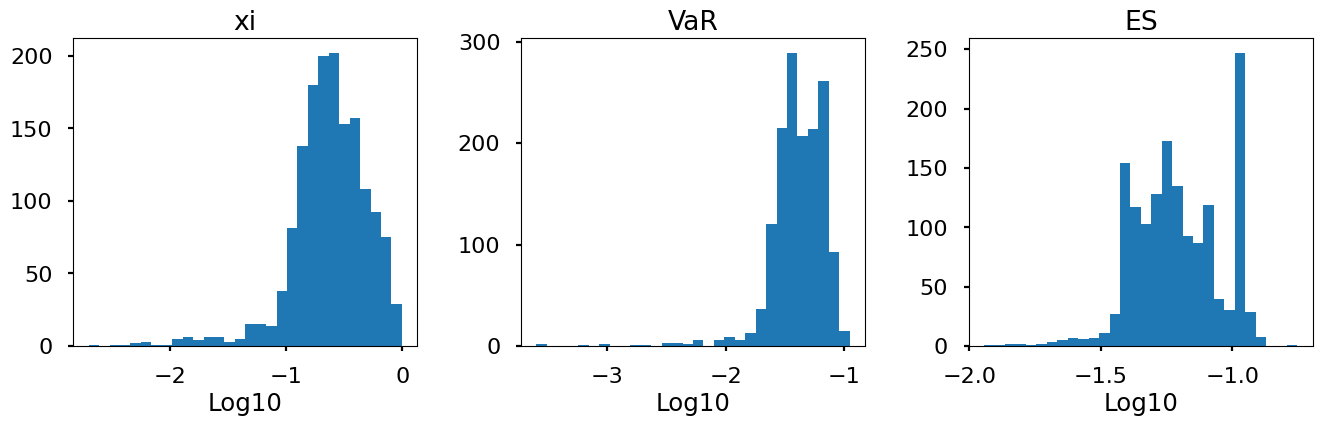

In [26]:
axis = df_res[
    (df_res['xi']<1) &
    (df_res['xi']>0)
][['xi', 'VaR', 'ES']].applymap(np.log10).hist(
    bins=30, grid=False, layout=(1,3), figsize=(16,4)
);

for ax in axis.flatten():
    ax.set_xlabel('Log10')

Threshold plots with confidence interval


In [27]:
def plot_confidence_interval(method='xi', log_y_bool=True, list_tickers=list_tickers, df_res=df_res):
    fig, axis = plt.subplots(nrows=5, ncols=3)
    list_ax = axis.flatten()[:len(list_tickers)]

    for ticker,ax in zip(list_tickers, list_ax):
        df_res.loc[ticker][[method]].plot(ax=ax, color='darkcyan')
        df_res.loc[ticker][f'{method}_low'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)
        df_res.loc[ticker][f'{method}_high'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)

        if method == 'xi':
            ax.axhline(1/2, color='grey')
            ax.axhline(1/3, color='grey')
            ax.axhline(1/4, color='grey')

        ax.invert_xaxis()
        ax.legend(loc='upper left')
        if log_y_bool:
            ax.set_yscale('log')

        ax2 = ax.twinx()
        df_res.loc[ticker][['pct_n']].rename(columns={'pct_n':'Nu/N'}).plot(ax=ax2, color='grey', alpha=0.5);
        ax2.set_yscale('log')
        ax2.legend(loc='upper right')

        if method == 'VaR':
            _se_u = df_res[
                (df_res['pct_n'] > 0.05) &
                (df_res['pct_n'] <= 0.1)
            ].loc[ticker].reset_index()['u']
            ax2.axvline(_se_u.max(), color='red')
            ax2.axvline(_se_u.min(), color='green')


        ax.set_title(ticker);
    fig.set_size_inches(20, 30)
    fig.tight_layout()


In [28]:
def plot_confidence_interval(method='xi',
                              log_y_bool=True,
                              list_tickers=list_tickers,
                              df_res=df_res,
                              ncols=3):
    nrows = int(np.ceil(len(list_tickers)/ncols))
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols)
    list_ax = axis.flatten()[:len(list_tickers)]

    for ticker,ax in zip(list_tickers, list_ax):
        df_res.loc[ticker][[method]].plot(ax=ax, color='darkcyan')
        df_res.loc[ticker][f'{method}_low'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)
        df_res.loc[ticker][f'{method}_high'].plot(ax=ax, color='darkcyan', alpha=0.3, label=None)

        if method == 'xi':
            ax.axhline(1, color='grey')
            ax.axhline(1/2, color='grey')
            ax.axhline(1/3, color='grey')
            ax.axhline(1/4, color='grey')

        ax.invert_xaxis()
        ax.legend(loc='upper left')
        if log_y_bool:
            ax.set_yscale('log')

        ax2 = ax.twinx()
        df_res.loc[ticker][['pct_n']].rename(columns={'pct_n':'Nu/N'}).plot(ax=ax2, color='grey', alpha=0.5);
        ax2.set_yscale('log')
        ax2.legend(loc='upper right')

        if method == 'VaR':
            _se_u = df_res[
                (df_res['pct_n'] > 0.05) &
                (df_res['pct_n'] <= 0.1)
            ].loc[ticker].reset_index()['u']
            ax2.axvline(_se_u.max(), color='red')
            ax2.axvline(_se_u.min(), color='green')


        ax.set_title(ticker);
    fig.set_size_inches(6*ncols, 5*nrows)
    fig.tight_layout()


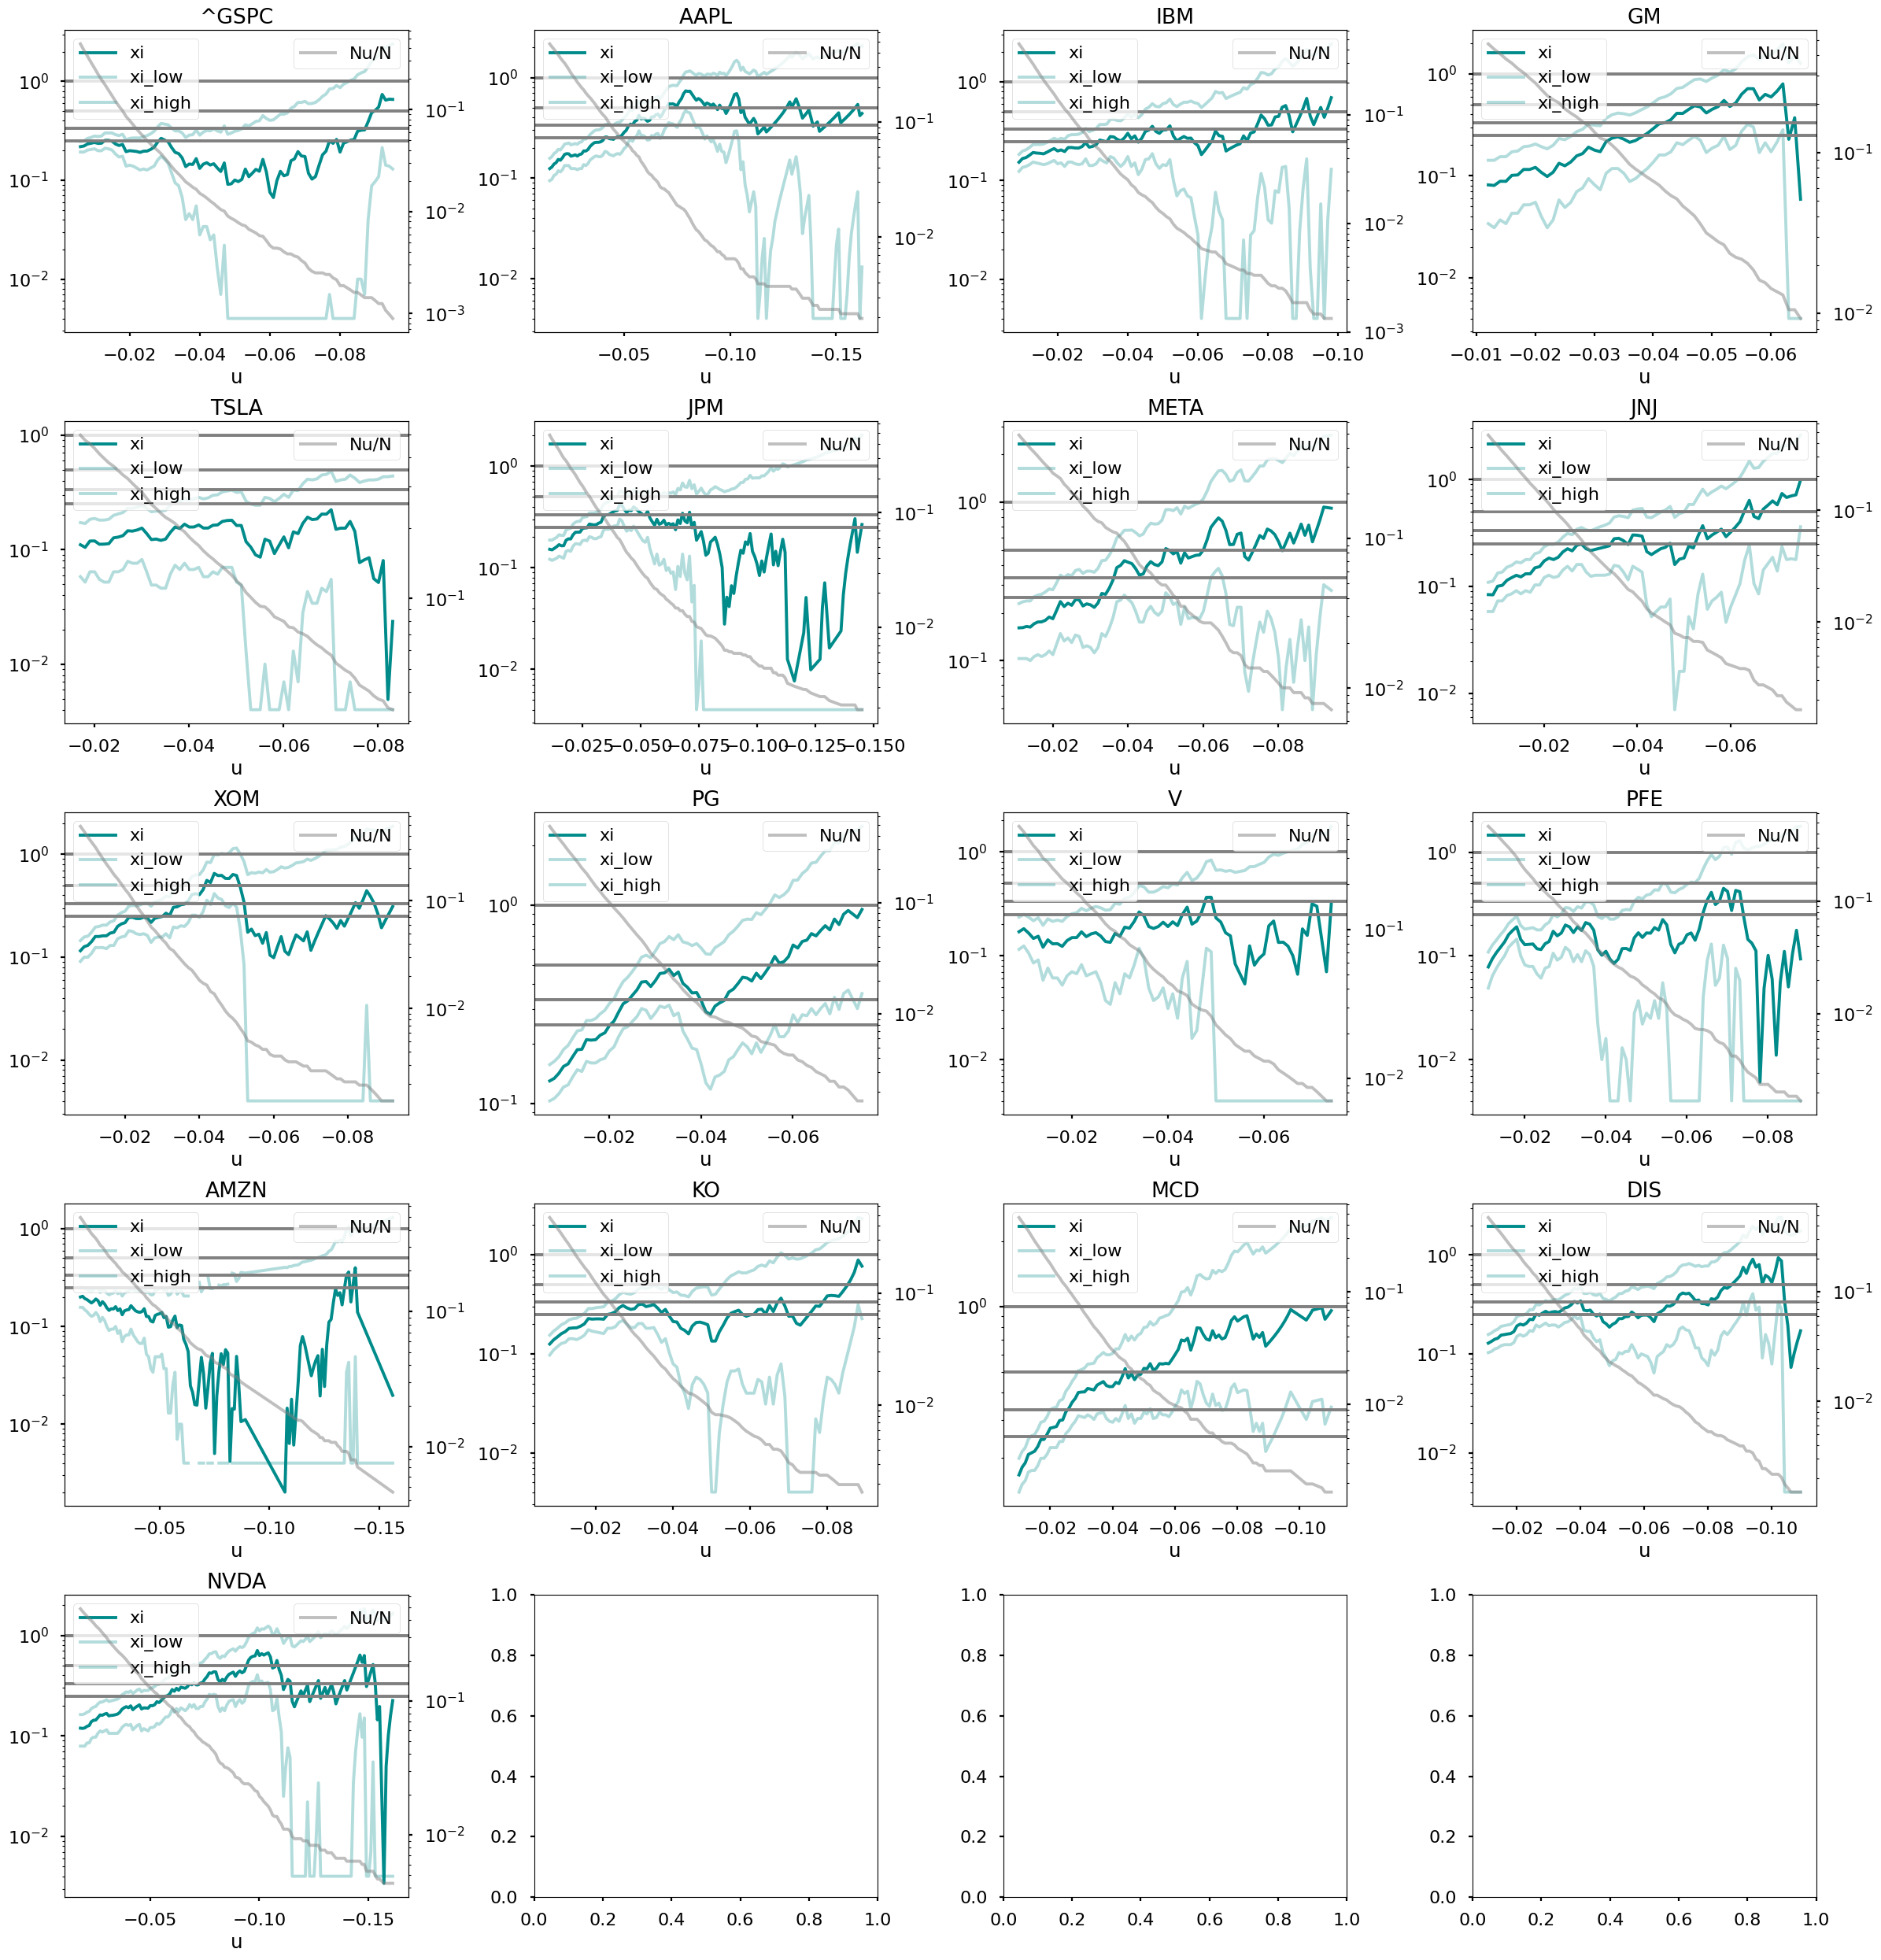

In [29]:
plot_confidence_interval(method='xi', log_y_bool=True, ncols=4)

VaR

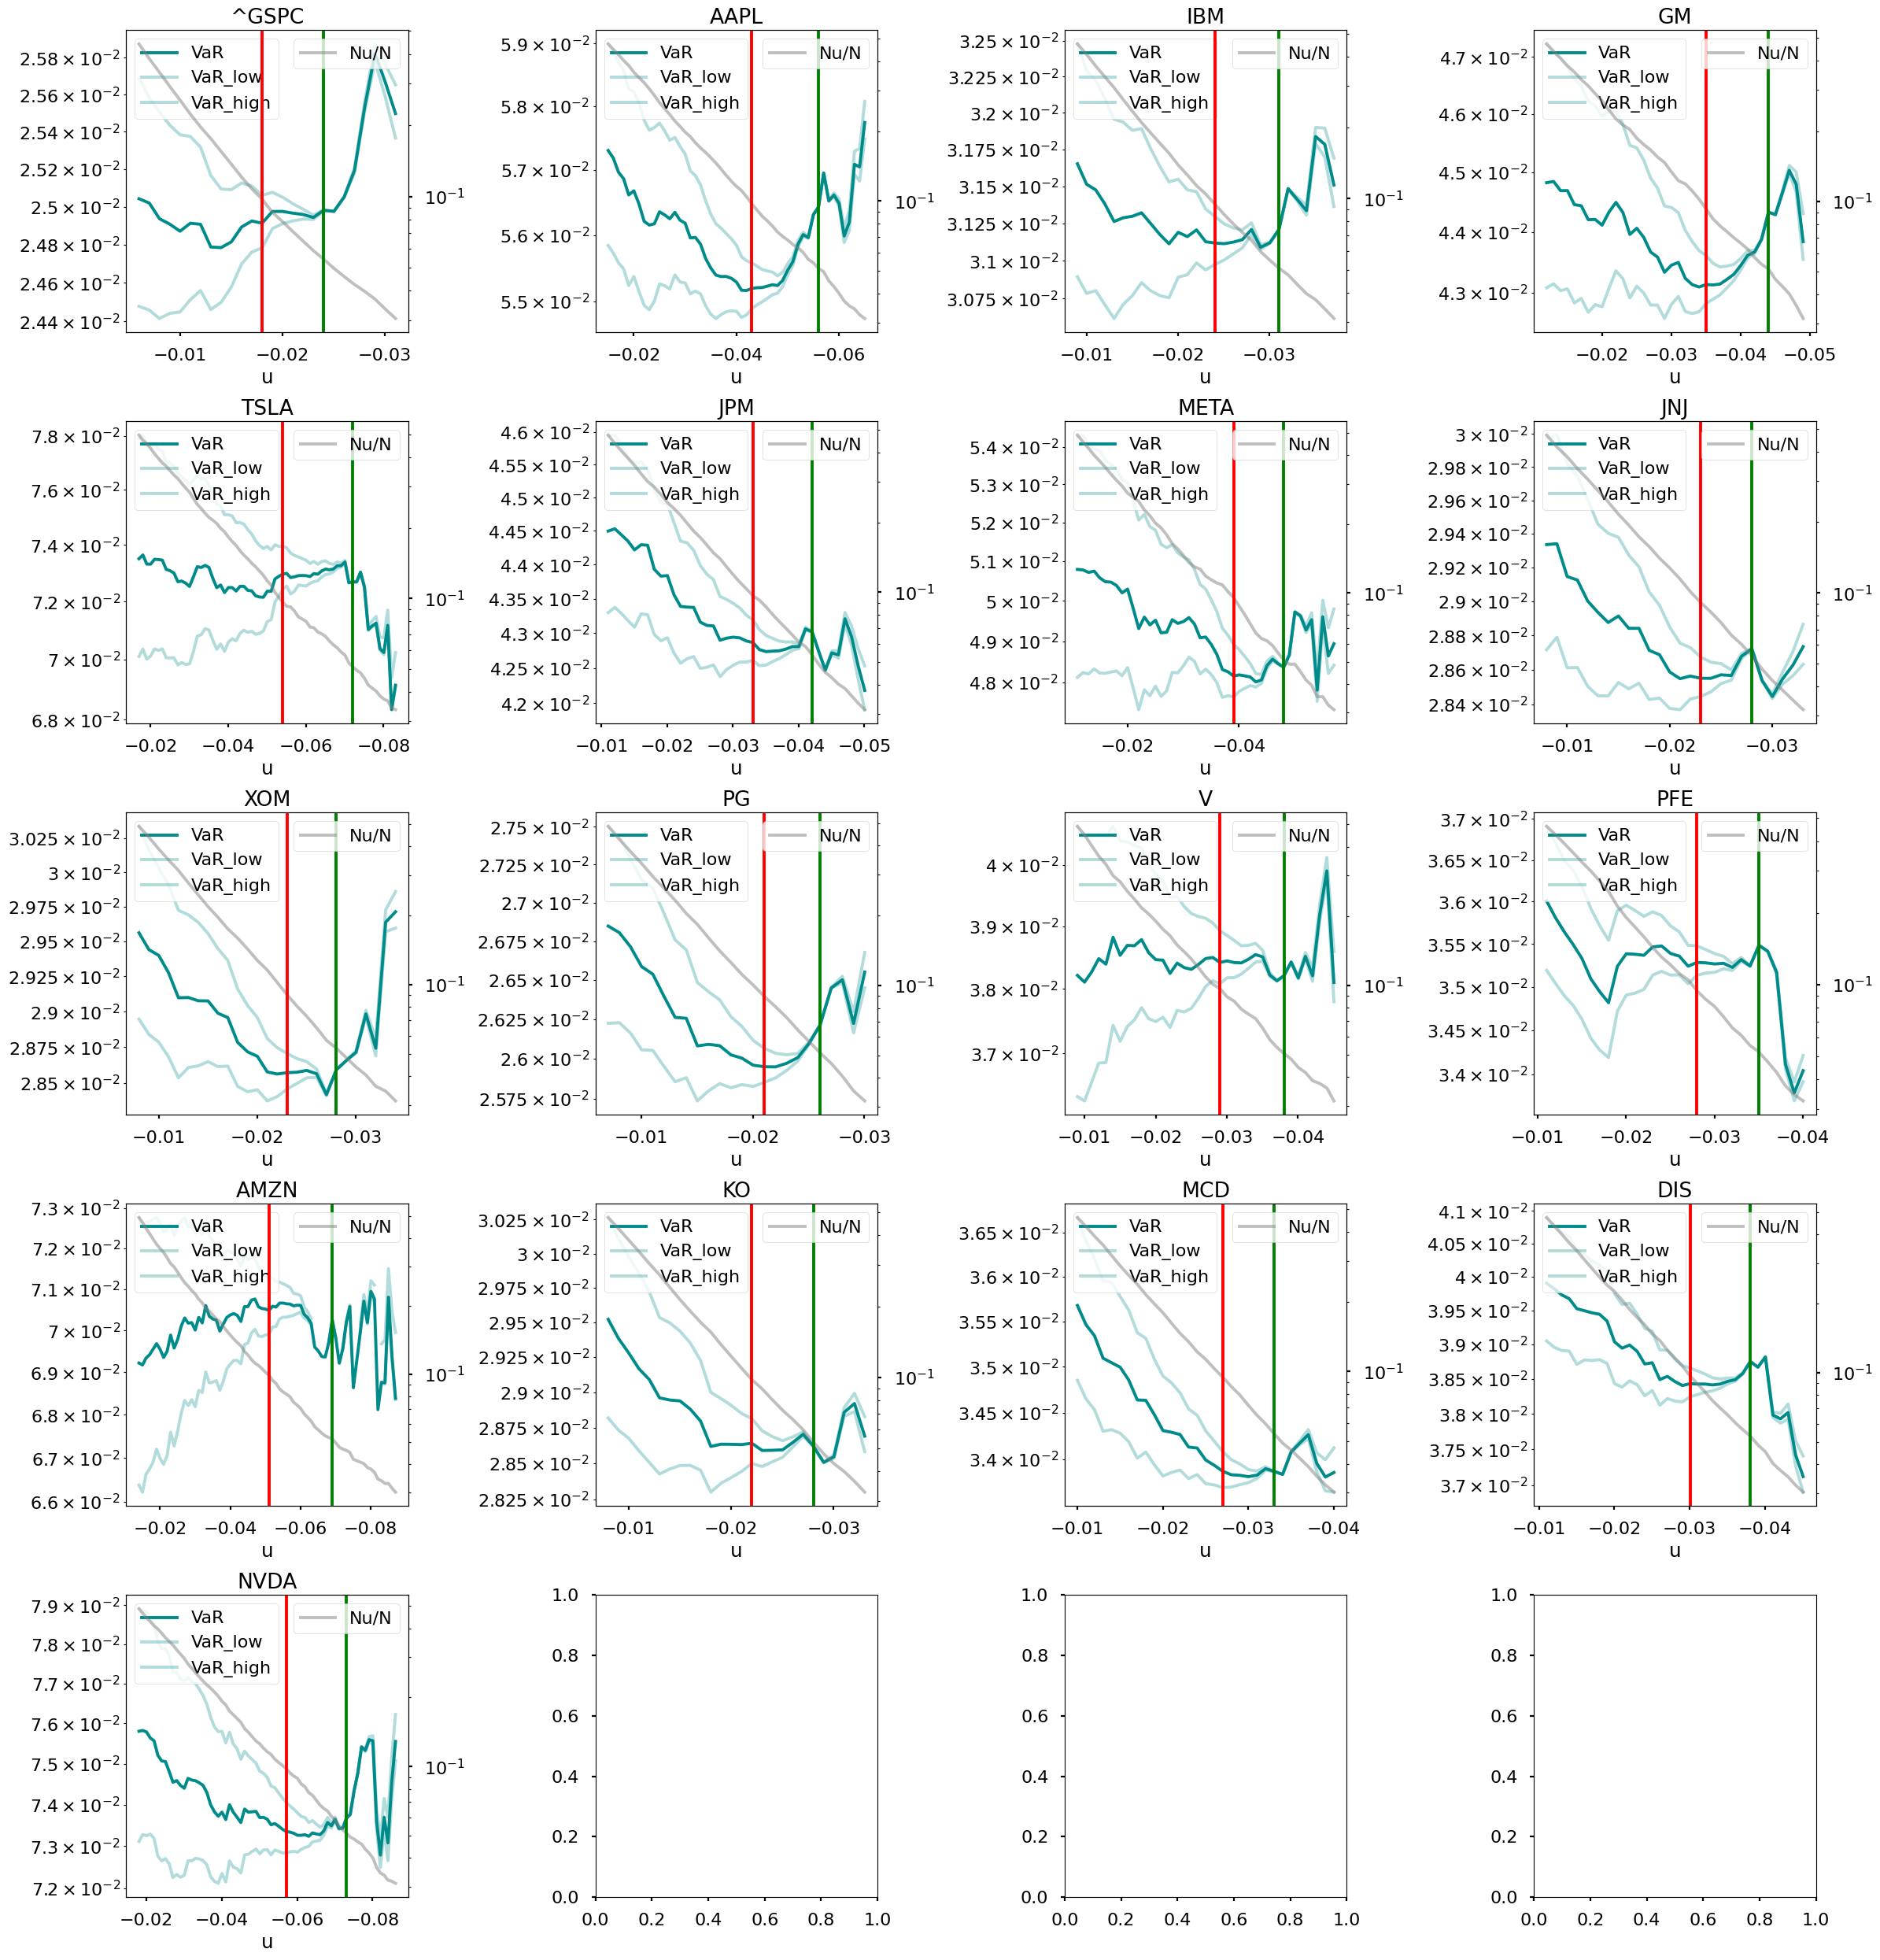

In [32]:
plot_confidence_interval(method='VaR', log_y_bool=True, df_res=df_res[df_res['pct_n'] > 0.03], ncols=4)

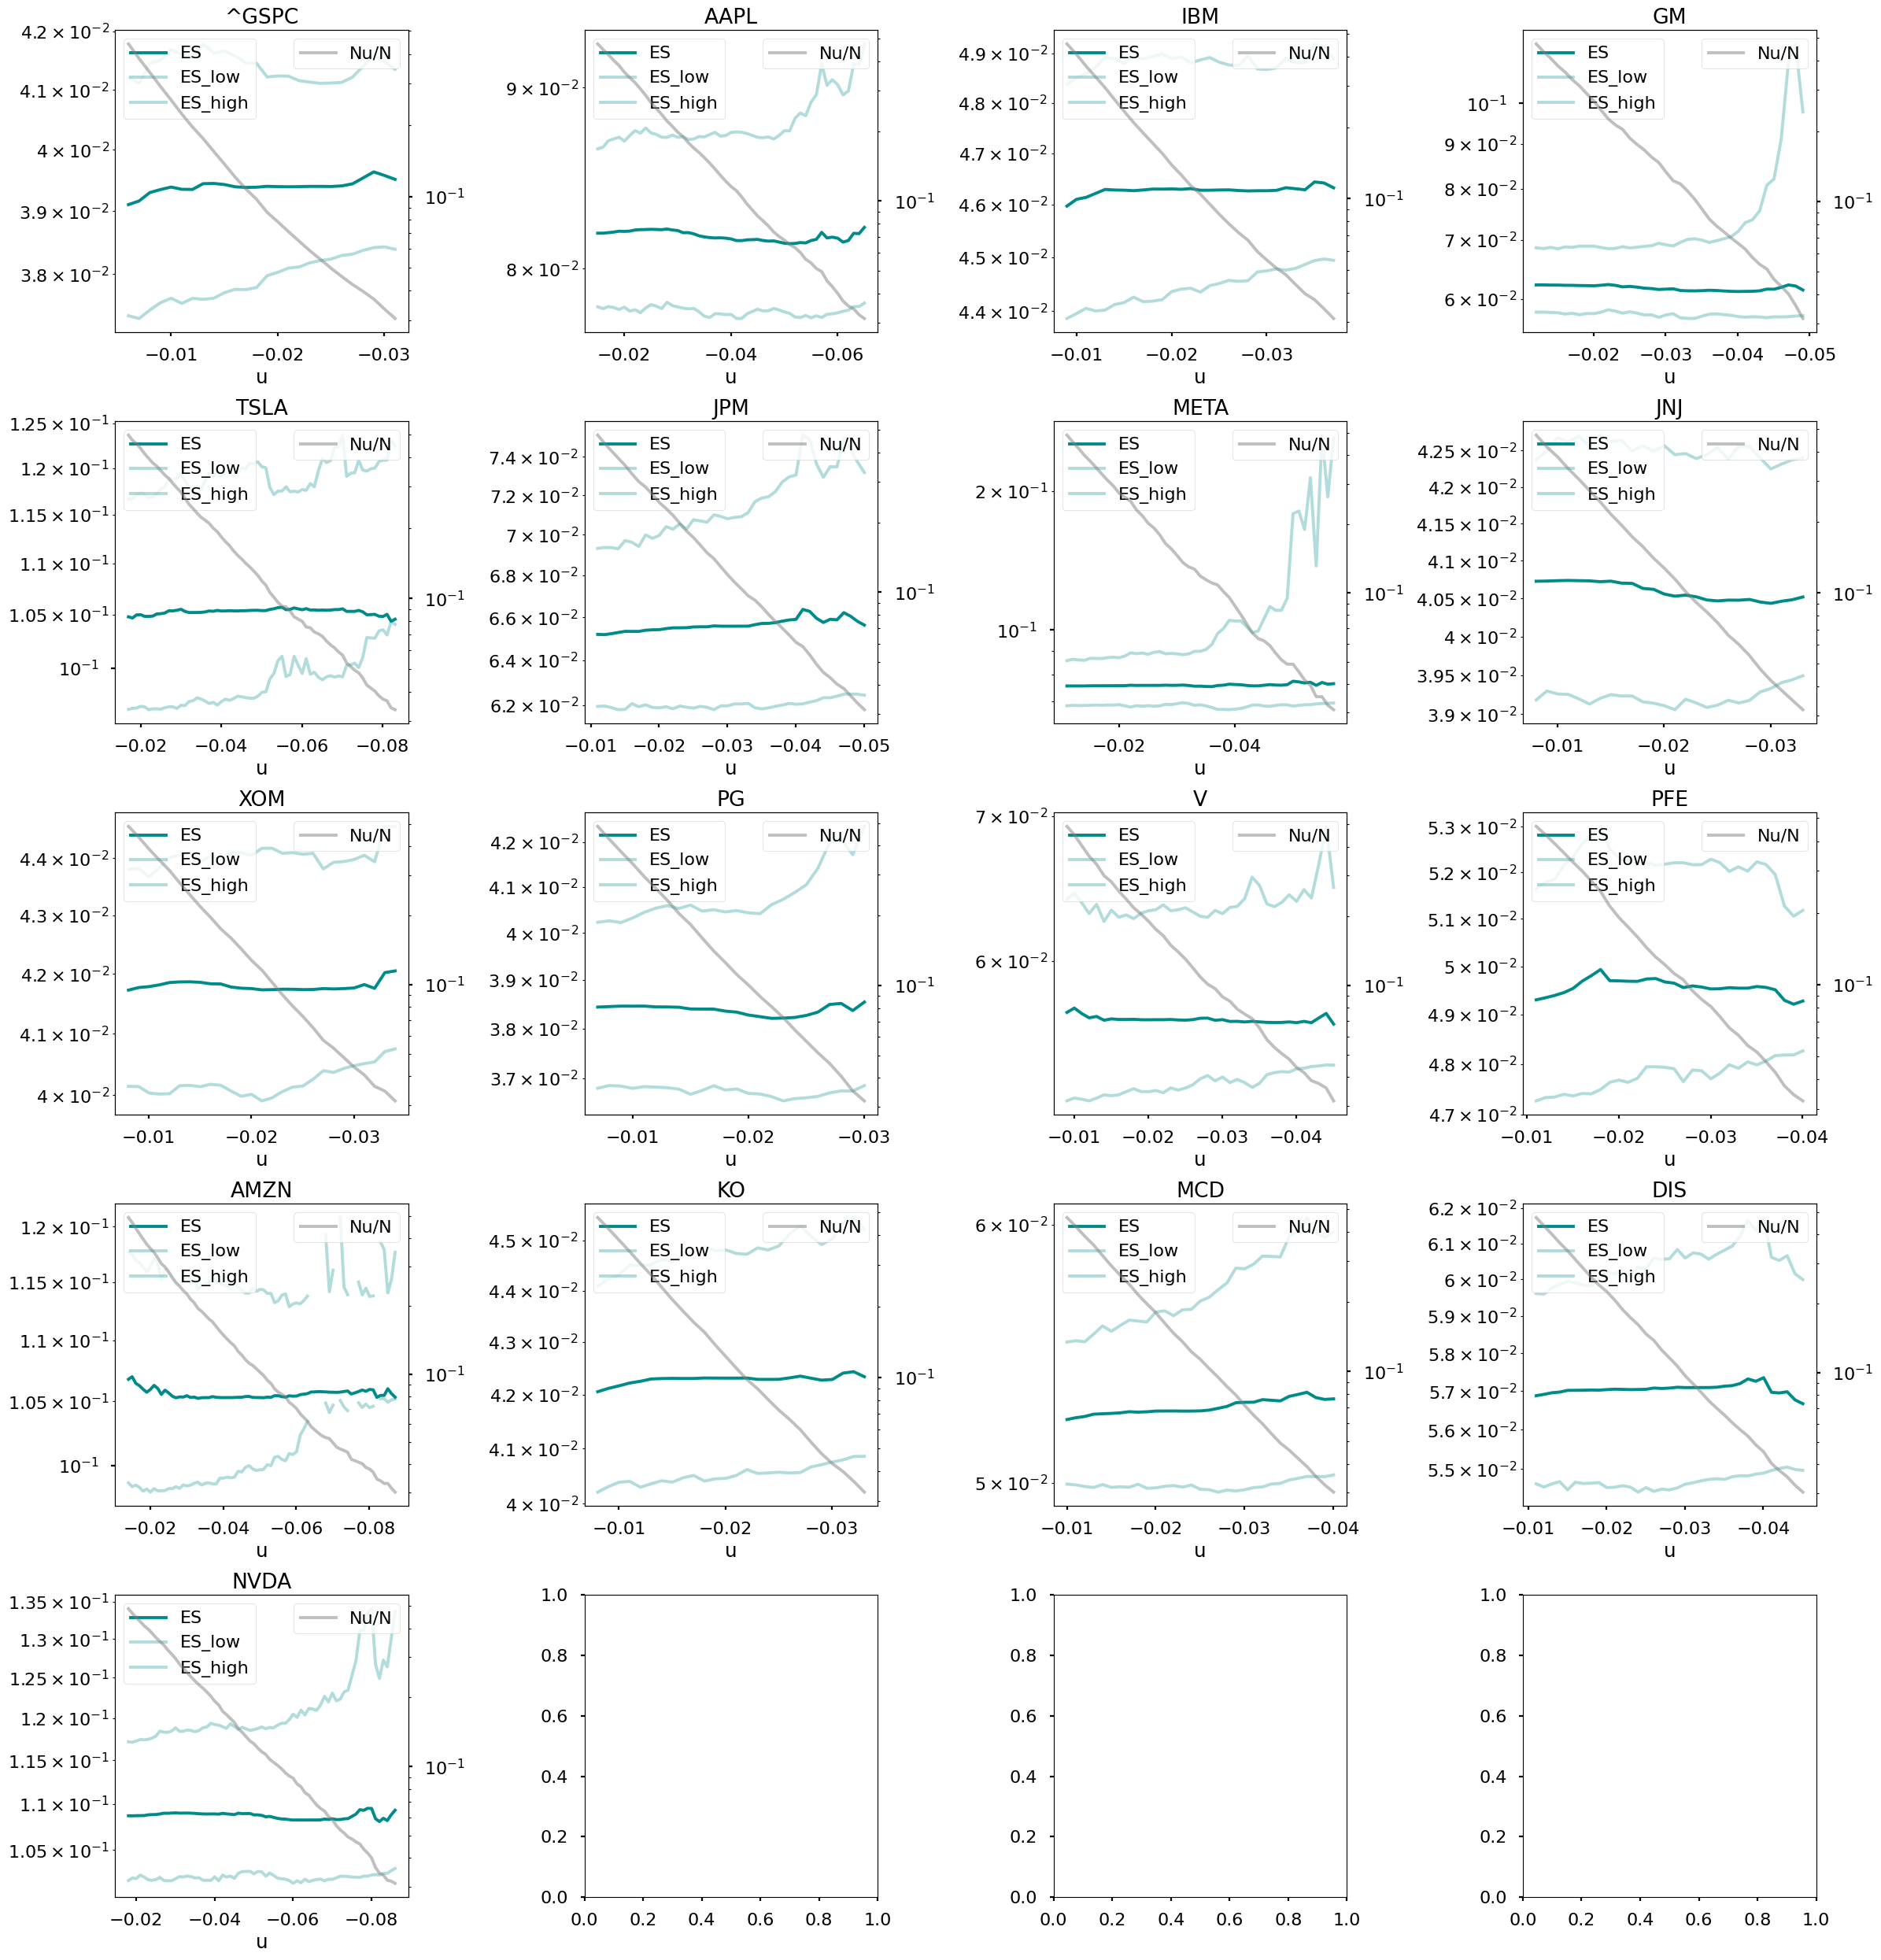

In [33]:
# Uncomment this cell for the results on ES, a.k.a. conditional VaR (recommended)
plot_confidence_interval(method='ES', log_y_bool=True, df_res=df_res[df_res['pct_n'] > 0.03], ncols=4)

VaR CI width summary

In [34]:
##########################################################
############# Compute VaR at different levels ############
##########################################################

def get_results_at_VaR_level(alpha=0.95,
                             list_experiment=list_experiment):
    '''
    Compute the results for VaR at a given level

    Args:
        - alpha: VaR level
    '''
    df_result = pd.concat(list_experiment)
    df_result['pct_n'] = df_result['N_u'] / df_result['N']

    df_result[['VaR_low', 'ES_low']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_low'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result[['VaR', 'ES']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result[['VaR_high', 'ES_high']] = df_result.apply(
        lambda se: pd.Series(VaR_ES(u=se['u'], c=se['xi_high'], scale=se['scale'],
                                    N=se['N'], Nu=se['N_u'], alpha=alpha)), axis=1)

    df_result = df_result.set_index(['ticker','u']).sort_index()

    return df_result

/usr/local/lib/python3.10/dist-packages/pandas/core/base.py:890: RuntimeWarning: invalid value encountered in log
  new_values = map_f(values, mapper)
/usr/local/lib/python3.10/dist-packages/pandas/core/base.py:890: RuntimeWarning: invalid value encountered in log
  new_values = map_f(values, mapper)


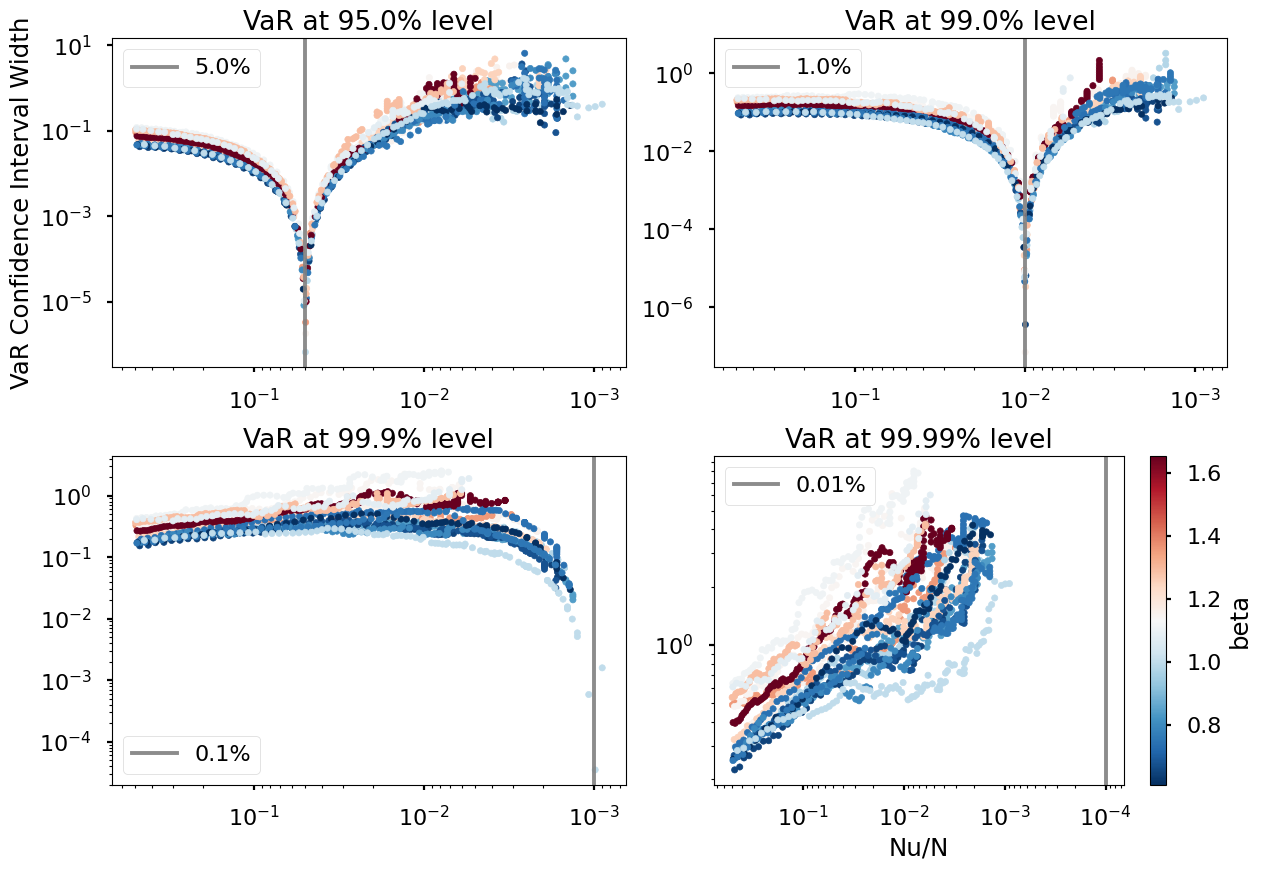

In [35]:
fig, axis = plt.subplots(2,2)
axis = axis.flatten()

list_alpha = [0.95, 0.99, 0.999, 0.9999]

for i, alpha in enumerate(list_alpha):
    _df = get_results_at_VaR_level(alpha=alpha)

    _df = _df.reset_index()
    _df['log_VaR_CI'] = _df.apply(
        lambda se: (se['VaR_high']/se['VaR_low']), axis=1
    ).map(np.log).replace(0, np.nan)
    ax = axis[i]

    # Add label at the 4th graph
    if i != 3:
        _df = _df.rename(columns={'beta':''})
        _df.plot.scatter(y='log_VaR_CI', x='pct_n', c=_df[''].to_list(), cmap='RdBu_r', ax=ax)
    else:
        _df.plot.scatter(y='log_VaR_CI', x='pct_n', c='beta', cmap='RdBu_r', ax=ax)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.invert_xaxis()

    if i == 0:
        ax.set_ylabel('VaR Confidence Interval Width')
    else:
        ax.set_ylabel('')

    if i == 3:
        ax.set_xlabel('Nu/N')
    else:
        ax.set_xlabel('')

    ax.xaxis.get_label().set_visible(True)
    ax.tick_params(axis='x', bottom=True, labelbottom=True)

    ax.axvline(1-alpha, color='grey', alpha=0.9, label=f'{np.round(100*(1-alpha), 2)}%')

    ax.legend()

    ax.set_title(f'VaR at {100*alpha}% level');

fig.tight_layout()

Linear regression on VaR CI log width


In [36]:
df_var_extreme = get_results_at_VaR_level(alpha=0.9999)
df_var_extreme = df_var_extreme[df_var_extreme['VaR_low'] > 0]

df_var_extreme = df_var_extreme.reset_index()
df_var_extreme['log_VaR_CI'] = df_var_extreme.apply(
    lambda se: (se['VaR_high']/se['VaR_low']), axis=1
).map(np.log)
# ax = df_var_extreme.plot.scatter(y='log_VaR_CI', x='pct_n', c='beta', cmap='RdBu_r')

df_var_extreme = df_var_extreme[['log_VaR_CI', 'pct_n', 'beta']]
df_var_extreme['log_VaR_CI'] = df_var_extreme['log_VaR_CI'].map(np.log)
df_var_extreme['pct_n'] = df_var_extreme['pct_n'].map(np.log)

import statsmodels.api as sm

Y = df_var_extreme['log_VaR_CI']
X = df_var_extreme[['pct_n', 'beta']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params.rename('linear regression').to_frame()

,linear regression
const,-1.902980
pct_n,-0.363087
beta,0.675430


In [37]:
# print(results.summary().as_latex())
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_VaR_CI   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1555.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:45:15   Log-Likelihood:                -1008.0
No. Observations:                1688   AIC:                             2022.
Df Residuals:                    1685   BIC:                             2038.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9030      0.051    -37.325      0.000      -2.003      -1.803
pct_n         -0.3631      0.007    -54.843      0.000      -0.376      -0.350
beta           0.6754      0.037     18.466      0.000       0.604       0.747
==============================================================================
Omnibus:                       86.015   Durbin-Watson:                   0.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.221
Skew:                           0.422   Prob(JB):                     2.63e-30
Kurtosis:                       4.106   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

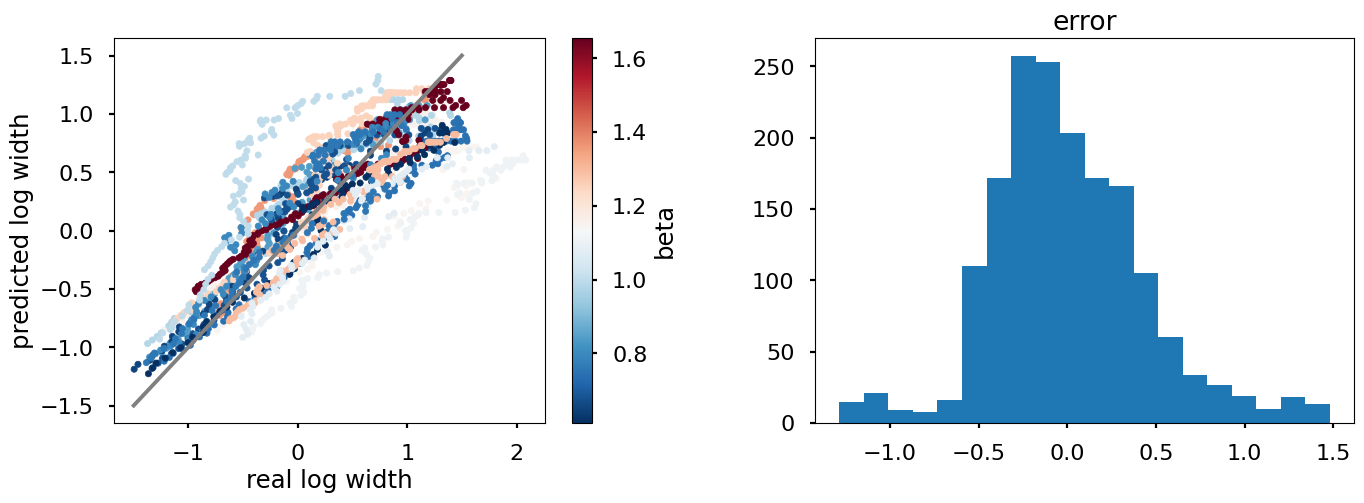

In [38]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2)

df_var_extreme['predicted_width'] = results.predict(X)
df_var_extreme.plot.scatter(x='log_VaR_CI', y='predicted_width', c='beta', cmap='RdBu_r', ax=ax)

ax.set_ylabel('predicted log width')

ax.set_xlabel('real log width')
ax.xaxis.get_label().set_visible(True)
ax.tick_params(axis='x', bottom=True, labelbottom=True)
ax.plot([-1.5, 1.5],[-1.5, 1.5], color='grey')
ax.set_title('');


df_var_extreme['error'] = df_var_extreme['log_VaR_CI'] - df_var_extreme['predicted_width']
df_var_extreme[['error']].hist(bins=20, ax=ax1, grid=False)

fig.set_size_inches(16,5)